In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    'mibor_historical_data.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%d/%m/%Y'
)
df.sort_index(inplace=True)

# Convert rates from percentage to decimal
df['MIBOR_Rate'] = df['MIBOR_Rate'] / 100

In [13]:
print(df.head())
print(df.info())
print(df.describe())

            MIBOR_Rate
Date                  
2023-06-01      0.0639
2023-06-02      0.0644
2023-06-05      0.0637
2023-06-06      0.0639
2023-06-07      0.0649
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2023-06-01 to 2025-05-27
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MIBOR_Rate  478 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB
None
       MIBOR_Rate
count  478.000000
mean     0.066216
std      0.002561
min      0.058500
25%      0.065000
50%      0.066500
75%      0.068300
max      0.079000


In [14]:
df.dropna(inplace=True)

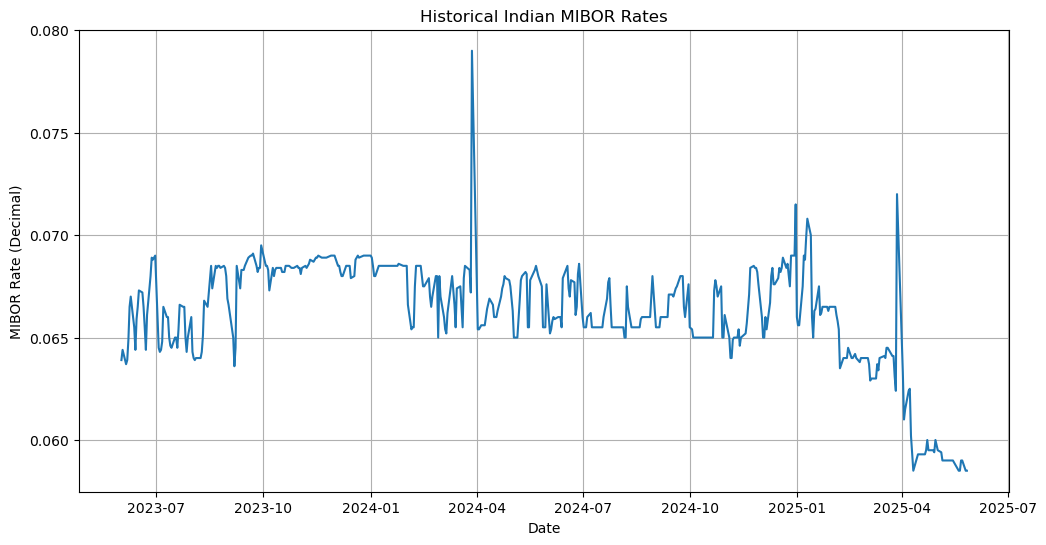

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MIBOR_Rate'])
plt.title('Historical Indian MIBOR Rates')
plt.xlabel('Date')
plt.ylabel('MIBOR Rate (Decimal)')
plt.grid(True)
plt.show()

In [16]:
from scipy.optimize import minimize

def vasicek_log_likelihood(params, rates, dt):
    k, theta, sigma = params
    n = len(rates)
    
    # Calculate drift and volatility terms
    drift = k * (theta - rates[:-1]) * dt
    diffusion = sigma * np.sqrt(dt)

    # Calculate residuals
    residuals = rates[1:] - (rates[:-1] + drift)
    
    # Log-likelihood function (assuming normal distribution of residuals)
    # L = -0.5 * N * log(2 * pi) - N * log(sigma_eff) - 0.5 * sum((residuals / sigma_eff)^2)
    # sigma_eff = sigma * sqrt(dt)
    
    # Avoid log of zero or negative for sigma
    if sigma <= 0:
        return np.inf

    log_likelihood = -0.5 * (n - 1) * np.log(2 * np.pi * diffusion**2) - 0.5 * np.sum((residuals**2) / (diffusion**2))
    return -log_likelihood # We want to minimize the negative log-likelihood

def calibrate_vasicek(rates, dt):
    # Initial guess for parameters (k, theta, sigma)
    # k: speed of mean reversion, should be > 0
    # theta: long-term mean, usually around the historical average
    # sigma: volatility, often a small positive number
    
    initial_guess = [0.5, np.mean(rates), 0.01]
    
    # Bounds for parameters (k, theta, sigma)
    # k > 0, theta can be positive or negative, sigma > 0
    bounds = [(1e-5, None), (None, None), (1e-5, None)] 
    
    result = minimize(vasicek_log_likelihood, initial_guess, args=(rates, dt), bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        k, theta, sigma = result.x
        print(f"\nVasicek Model Calibration Results:")
        print(f"  k (speed of mean reversion): {k:.4f}")
        print(f"  theta (long-term mean): {theta:.4f}")
        print(f"  sigma (volatility): {sigma:.4f}")
        return k, theta, sigma
    else:
        print("Vasicek calibration failed:", result.message)
        return None, None, None

# Prepare data for calibration
rates = df['MIBOR_Rate'].values
dt = 1/252 # Assuming 252 trading days in a year

k_v, theta_v, sigma_v = calibrate_vasicek(rates, dt)


Vasicek Model Calibration Results:
  k (speed of mean reversion): 0.5009
  theta (long-term mean): 0.0604
  sigma (volatility): 0.0213


In [18]:
# For Hull-White, we'll primarily calibrate k and sigma from historical short rates.
# The time-dependent theta(t) is typically calibrated to match the initial yield curve.
# Without a full yield curve, we'll approximate theta(t) using the long-term mean from Vasicek
# or consider it as a constant for simulation purposes, with r0 being the starting point.

# We can re-use the Vasicek log-likelihood function for calibrating k and sigma from short rates,
# as the dynamics for dr_t are similar when considering only the historical spot rate.
# The true power of HW comes from fitting the yield curve.

# Let's assume for simplicity we calibrate k and sigma from historical data, similar to Vasicek.
# The key difference in Hull-White is how forward rates are derived, which involves fitting the initial yield curve.
# Since we don't have a yield curve, we'll assume a constant theta(t) that corresponds to the long-term mean from the Vasicek calibration.

# Calibrate k and sigma for Hull-White using the same Vasicek function.
# This is a practical simplification for short-rate data only.
# The true Hull-White would involve fitting to a yield curve.

# CORRECTED LINE: unpack all three returned values
k_hw, theta_hw_from_calibration, sigma_hw_from_vasicek = calibrate_vasicek(rates, dt) # Re-using function for k and sigma

# For Hull-White, we need a time-dependent theta(t). Without a yield curve, this is complex.
# A common simplification is to make theta(t) such that the model matches the current yield curve.
# Since we don't have a yield curve, we can proceed by setting a long-term mean.
# We'll use the theta from the Vasicek model as a proxy for the long-term mean for HW,
# and note this simplification.
theta_hw = theta_v # Use Vasicek's theta as a reasonable long-term mean
# Or, if you prefer to use the theta obtained directly from the HW-like calibration:
# theta_hw = theta_hw_from_calibration
# For consistency with the explanation, let's stick to using theta_v as the proxy for theta_hw

if k_hw is None or theta_hw is None or sigma_hw_from_vasicek is None:
    print("Hull-White calibration (simplified) failed.")
else:
    print(f"\nHull-White Model Calibration Results (Simplified):")
    print(f"  k (speed of mean reversion): {k_hw:.4f}")
    print(f"  theta (long-term mean assumed): {theta_hw:.4f}") # Using theta_v as proxy
    print(f"  sigma (volatility): {sigma_hw_from_vasicek:.4f}")
    sigma_hw = sigma_hw_from_vasicek # Rename for clarity


Vasicek Model Calibration Results:
  k (speed of mean reversion): 0.5009
  theta (long-term mean): 0.0604
  sigma (volatility): 0.0213

Hull-White Model Calibration Results (Simplified):
  k (speed of mean reversion): 0.5009
  theta (long-term mean assumed): 0.0604
  sigma (volatility): 0.0213


In [19]:
def vasicek_zcb_price(r_t, T_minus_t, k, theta, sigma):
    B = (1 - np.exp(-k * T_minus_t)) / k
    A = np.exp((theta - sigma**2 / (2 * k**2)) * (B - T_minus_t) - (sigma**2 / (4 * k)) * B**2)
    return A * np.exp(-B * r_t)

def hull_white_zcb_price(r_t, T_minus_t, k, theta_hw, sigma_hw):
    # This implementation assumes a constant theta for simplicity,
    # effectively making it a Vasicek-like model for historical short-rate data.
    # The true Hull-White would involve fitting to the initial yield curve.
    
    B = (1 - np.exp(-k * T_minus_t)) / k
    
    # For a constant theta(t) = theta_hw:
    integral_theta_B = theta_hw * (T_minus_t - B) # Integral of theta * B(s,T)ds
    
    # The formula for A(t,T) in Hull-White when theta(t) is constant is:
    # A(t,T) = exp[ (theta_hw - sigma_hw^2/(2*k^2)) * (B - T_minus_t) - (sigma_hw^2/(4*k)) * B^2 ]
    # This is essentially the same as Vasicek if theta_hw is constant.
    # The key difference in actual HW is that theta(t) is chosen to fit the current yield curve.
    # Given our calibration approach (only short rates), we'll use the simplified A for HW.
    
    # We will use the Vasicek A function with HW parameters for consistency in this simplified approach.
    A = np.exp((theta_hw - sigma_hw**2 / (2 * k**2)) * (B - T_minus_t) - (sigma_hw**2 / (4 * k)) * B**2)
    
    return A * np.exp(-B * r_t)

def calculate_interest_rate(zcb_price, T_minus_t):
    if zcb_price <= 0:
        return np.nan # Handle invalid prices
    return -np.log(zcb_price) / T_minus_t

# Get the last observed MIBOR rate as the current short rate (r_t)
current_r0 = df['MIBOR_Rate'].iloc[-1]
print(f"\nLast observed MIBOR rate (r0): {current_r0:.4f}")

# Tenor periods in years
tenors = [3.5, 4.5, 5.5]

# Calculate and store results
results = []

print("\n--- Vasicek Model Interest Rates ---")
for tenor in tenors:
    if k_v is not None and theta_v is not None and sigma_v is not None:
        price_v = vasicek_zcb_price(current_r0, tenor, k_v, theta_v, sigma_v)
        rate_v = calculate_interest_rate(price_v, tenor)
        print(f"  {tenor} years: ZCB Price = {price_v:.4f}, Interest Rate = {rate_v * 100:.4f}%")
        results.append({'Model': 'Vasicek', 'Tenor': tenor, 'Interest_Rate': rate_v, 'ZCB_Price': price_v})
    else:
        print(f"  Vasicek parameters not calibrated for {tenor} years.")

print("\n--- Hull-White Model Interest Rates (Simplified) ---")
for tenor in tenors:
    if k_hw is not None and theta_hw is not None and sigma_hw is not None:
        price_hw = hull_white_zcb_price(current_r0, tenor, k_hw, theta_hw, sigma_hw)
        rate_hw = calculate_interest_rate(price_hw, tenor)
        print(f"  {tenor} years: ZCB Price = {price_hw:.4f}, Interest Rate = {rate_hw * 100:.4f}%")
        results.append({'Model': 'Hull-White', 'Tenor': tenor, 'Interest_Rate': rate_hw, 'ZCB_Price': price_hw})
    else:
        print(f"  Hull-White parameters not calibrated for {tenor} years.")

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)


Last observed MIBOR rate (r0): 0.0585

--- Vasicek Model Interest Rates ---
  3.5 years: ZCB Price = 0.8128, Interest Rate = 5.9207%
  4.5 years: ZCB Price = 0.7659, Interest Rate = 5.9266%
  5.5 years: ZCB Price = 0.7217, Interest Rate = 5.9307%

--- Hull-White Model Interest Rates (Simplified) ---
  3.5 years: ZCB Price = 0.8128, Interest Rate = 5.9207%
  4.5 years: ZCB Price = 0.7659, Interest Rate = 5.9266%
  5.5 years: ZCB Price = 0.7217, Interest Rate = 5.9307%

Results Summary:
        Model  Tenor  Interest_Rate  ZCB_Price
0     Vasicek    3.5       0.059207   0.812837
1     Vasicek    4.5       0.059266   0.765904
2     Vasicek    5.5       0.059307   0.721670
3  Hull-White    3.5       0.059207   0.812837
4  Hull-White    4.5       0.059266   0.765904
5  Hull-White    5.5       0.059307   0.721670


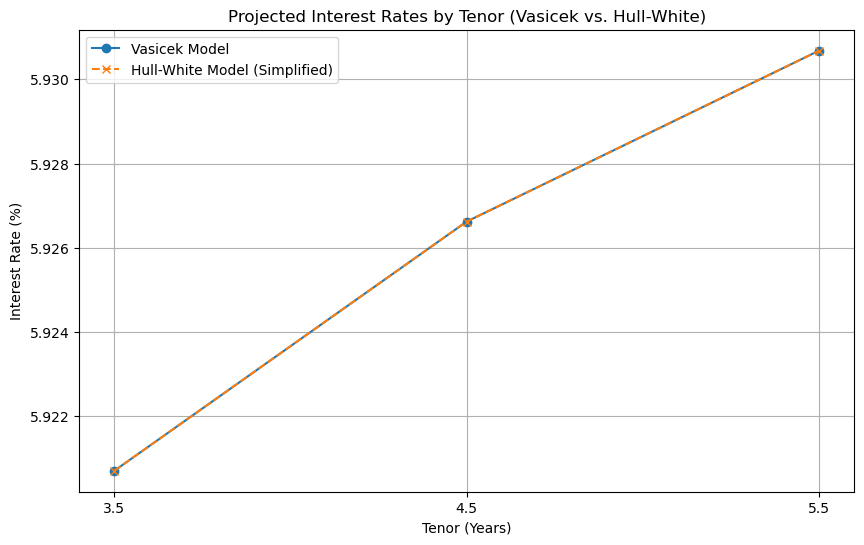

In [20]:
plt.figure(figsize=(10, 6))

# Vasicek Plot
vasicek_results = results_df[results_df['Model'] == 'Vasicek']
plt.plot(vasicek_results['Tenor'], vasicek_results['Interest_Rate'] * 100, marker='o', linestyle='-', label='Vasicek Model')

# Hull-White Plot
hull_white_results = results_df[results_df['Model'] == 'Hull-White']
plt.plot(hull_white_results['Tenor'], hull_white_results['Interest_Rate'] * 100, marker='x', linestyle='--', label='Hull-White Model (Simplified)')

plt.title('Projected Interest Rates by Tenor (Vasicek vs. Hull-White)')
plt.xlabel('Tenor (Years)')
plt.ylabel('Interest Rate (%)')
plt.xticks(tenors)
plt.grid(True)
plt.legend()
plt.show()